In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv(r"C:\Users\Sanskar Bansal\Desktop\Time Series Forecasting and Anomaly Detection for Household Energy Consumption\Datasets\electricity_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'].dt.year == 2020]
df.reset_index(drop=True, inplace=True)

In [10]:
df.head(3)

,Date,Total_Consumption
0,2020-01-01,10.6
1,2020-01-02,11.5
2,2020-01-03,24.3


In [11]:
df.tail()

,Date,Total_Consumption
359,2020-12-27,13.7
360,2020-12-28,12.9
361,2020-12-29,10.1
362,2020-12-30,20.1
363,2020-12-31,9.6


In [12]:
df.shape

(364, 2)

In [13]:
import math
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import matplotlib.pyplot as plt

actual_vals = df.Total_Consumption.values
actual_log = np.log10(actual_vals)

train, test = actual_vals[0:-80], actual_vals[-80:]
train_log, test_log = np.log10(train), np.log10(test)
my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, 7)

C:\Users\Sanskar Bansal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sanskar Bansal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


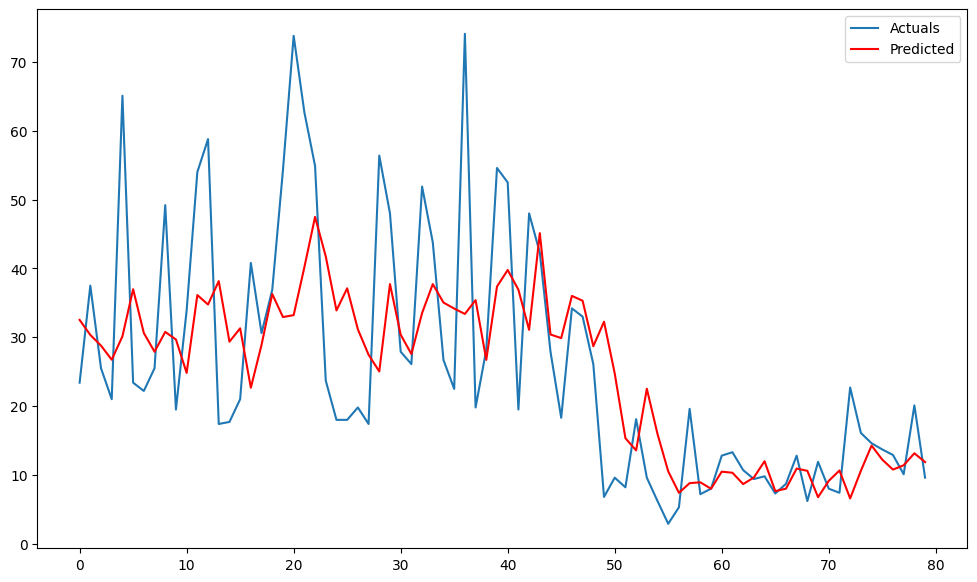

In [14]:
history = [x for x in train_log]
predictions = list()
predict_log=list()
for t in range(len(test_log)):
    model = sm.tsa.SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = test_log[t]
    history.append(obs)
   # print('predicted=%f, expected=%f' % (output[0], obs))
#error = math.sqrt(mean_squared_error(test_log, predict_log))
#print('Test rmse: %.3f' % error)
# plot
figsize=(12, 7)
plt.figure(figsize=figsize)
pyplot.plot(test,label='Actuals')
pyplot.plot(predictions, color='red',label='Predicted')
pyplot.legend(loc='upper right')
pyplot.show()

In [15]:
df_preds = df[-80:]
df_preds['Predicted_Consumption'] = predictions

In [19]:
import plotly.graph_objects as go
import plotly.offline as py

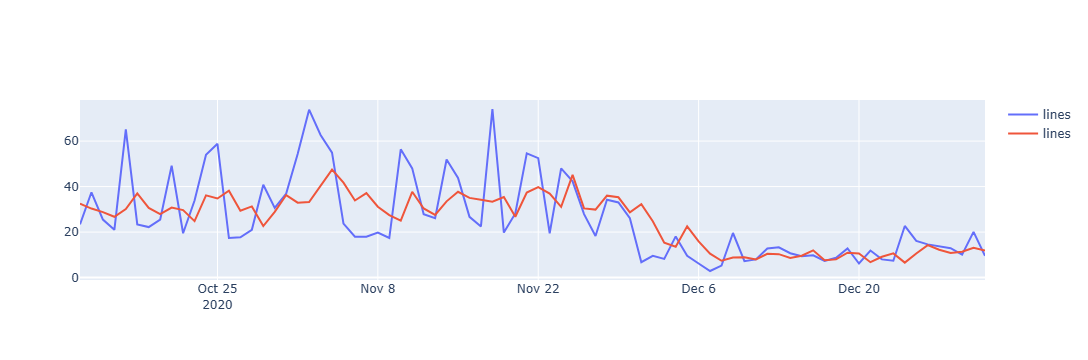

In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_preds['Date'], y=df_preds['Total_Consumption'],
                    mode='lines',
                    name='lines'))
fig.add_trace(go.Scatter(x=df_preds['Date'], y=df_preds['Predicted_Consumption'],
                    mode='lines',
                    name='lines'))

In [23]:
new_dates = pd.date_range(start='2021/01/01', end='2021/03/03')

In [24]:
train = df.Total_Consumption.values

my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, 62)

model = sm.tsa.SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
model_fit = model.fit()
output = model_fit.forecast(62)

In [25]:
listofzeros = [np.NaN] * 62

In [26]:
data_new = {'Date':new_dates,
            'Total_Consumption':listofzeros,
            'Predicted_Consumption':output}

df_new_preds = pd.DataFrame(data_new)

In [27]:
df_all = pd.concat([df_preds, df_new_preds], ignore_index=True)

In [28]:
df_all.head(2)

,Date,Total_Consumption,Predicted_Consumption
0,2020-10-13,23.4,32.523295
1,2020-10-14,37.5,30.339767


In [29]:
df_all['MAE'] = df_all['Total_Consumption'] - df_all['Predicted_Consumption']

### Threshold: 5

In [30]:
df_anoms = df_all[df_all['MAE'] >= 5]
df_anoms.reset_index(drop=True, inplace=True)

In [31]:
df_anoms.tail(2)

,Date,Total_Consumption,Predicted_Consumption,MAE
22,2020-12-25,16.1,10.598686,5.501314
23,2020-12-30,20.1,13.142995,6.957005


In [32]:
df_anoms['extra_MAE'] = df_anoms['MAE'] - 5

In [33]:
df_anoms['extra_MAE_cost'] = df_anoms['extra_MAE']*9

In [34]:
df_anoms.groupby(df_anoms['Date'].dt.month)['extra_MAE_cost'].sum()

Date
10     851.925092
11    1669.991886
12     175.565240
Name: extra_MAE_cost, dtype: float64

In [35]:
df_all.groupby(df_all['Date'].dt.month)['Total_Consumption'].sum().reset_index()['Total_Consumption']*7

0       0.0
1       0.0
2       0.0
3    4363.8
4    7870.8
5    2377.2
Name: Total_Consumption, dtype: float64

In [36]:
180/2300 # 8-15%

0.0782608695652174

### Threshold: 10

In [37]:
df_anoms = df_all[df_all['MAE'] >= 10]
df_anoms.reset_index(drop=True, inplace=True)

In [38]:
df_anoms.tail(2)

,Date,Total_Consumption,Predicted_Consumption,MAE
15,2020-12-09,19.6,8.804226,10.795774
16,2020-12-24,22.7,6.581040,16.118960


In [39]:
df_anoms['extra_MAE'] = df_anoms['MAE'] - 10

In [40]:
df_anoms['extra_MAE_cost'] = df_anoms['extra_MAE']*9

In [41]:
df_anoms.groupby(df_anoms['Date'].dt.month)['extra_MAE_cost'].sum()

Date
10     570.802598
11    1188.627634
12      62.232604
Name: extra_MAE_cost, dtype: float64

In [42]:
df_all.groupby(df_all['Date'].dt.month)['Total_Consumption'].sum().reset_index()['Total_Consumption']*7

0       0.0
1       0.0
2       0.0
3    4363.8
4    7870.8
5    2377.2
Name: Total_Consumption, dtype: float64

In [43]:
638/8862 # 8-15%

0.0719927781539156

### Threshold: 12

In [44]:
df_anoms = df_all[df_all['MAE'] >= 12]
df_anoms.reset_index(drop=True, inplace=True)

In [45]:
df_anoms.tail(2)

,Date,Total_Consumption,Predicted_Consumption,MAE
13,2020-11-24,48.0,31.081219,16.918781
14,2020-12-24,22.7,6.581040,16.118960


In [46]:
df_anoms['extra_MAE'] = df_anoms['MAE'] - 12

In [47]:
df_anoms['extra_MAE_cost'] = df_anoms['extra_MAE']*9

In [48]:
df_anoms.groupby(df_anoms['Date'].dt.month)['extra_MAE_cost'].sum()

Date
10     480.802598
11    1024.182793
12      37.070641
Name: extra_MAE_cost, dtype: float64

In [49]:
df_all.groupby(df_all['Date'].dt.month)['Total_Consumption'].sum().reset_index()['Total_Consumption']*7

0       0.0
1       0.0
2       0.0
3    4363.8
4    7870.8
5    2377.2
Name: Total_Consumption, dtype: float64

In [50]:
180/2300 # 8-15%

0.0782608695652174